In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

In [2]:
data1 = pd.read_csv("test1.csv", index_col=0).T
data2 = pd.read_csv("test2.csv", index_col=0).T
cell_types1 = pd.read_csv("celltypes1.csv", index_col = 0)
cell_types2 = pd.read_csv("celltypes2.csv", index_col = 0)
cell_types1.columns = ["cell_type"]
cell_types2.columns = ["cell_type"]
data = pd.concat([data1, data2])
data.index = data.index.str.replace(r"\.", "-", regex=True)
cell_types = pd.concat([cell_types1, cell_types2])
cell_types.index = data.index

In [53]:
data_merged = pd.concat([data, cell_types], axis=1)
count_occur = data_merged.sum()
# drop probes with no values
data_merged = data_merged.drop(count_occur.keys()[count_occur == 0], axis=1)
X, y = data_merged.iloc[:, :-1], data_merged["cell_type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

In [4]:
X.shape

(6500, 19434)

/Users/hongyudemacpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.48923076923076925

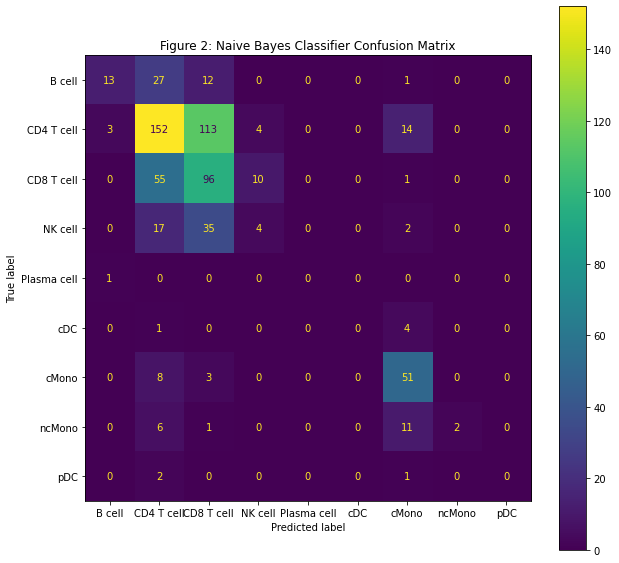

In [72]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gnb, X_test, y_test, labels = np.unique(y_test), ax=ax)
ax.set_title("Figure 2: Naive Bayes Classifier Confusion Matrix")
accuracy_score(gnb.predict(X_test), y_test)

In [73]:
cv_scores = cross_val_score(gnb, X, y, cv=5)
np.mean(cv_scores), cv_scores

(0.5152307692307693,
 array([0.51307692, 0.51461538, 0.52076923, 0.50230769, 0.52538462]))

In [6]:
pca_dict = {}
for i in range(2, 20):
    pca = PCA(n_components=i)
    gnb.fit(pca.fit_transform(X_train), y_train)
    pca_dict[i] = accuracy_score(y_test, gnb.predict(pca.transform(X_test)))

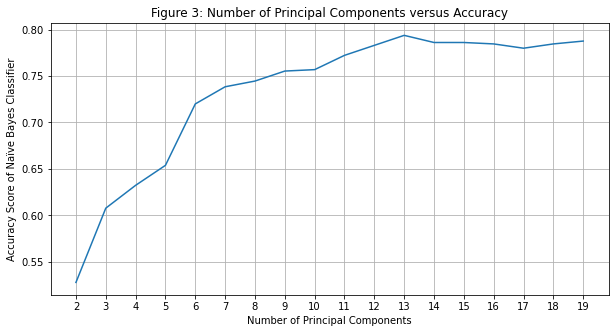

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pca_dict.keys(), pca_dict.values())
ax.set_xticks(list(pca_dict.keys()))
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Accuracy Score of Naïve Bayes Classifier")
ax.set_title("Figure 3: Number of Principal Components versus Accuracy")
ax.grid()

In [8]:
parameters = {'kernel':('linear', 'rbf', 'sigmoid')}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(PCA(n_components=15).fit_transform(X), y)

GridSearchCV(estimator=SVC(),
             param_grid={'kernel': ('linear', 'rbf', 'sigmoid')})

In [80]:
clf.best_estimator_, clf.best_score_

(SVC(kernel='linear'), 0.8858461538461538)

In [76]:
np.mean(cross_val_score(SVC(kernel="linear"), PCA(n_components=15).fit_transform(X), y, cv=5))

0.8866153846153846

/Users/hongyudemacpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.7846153846153846

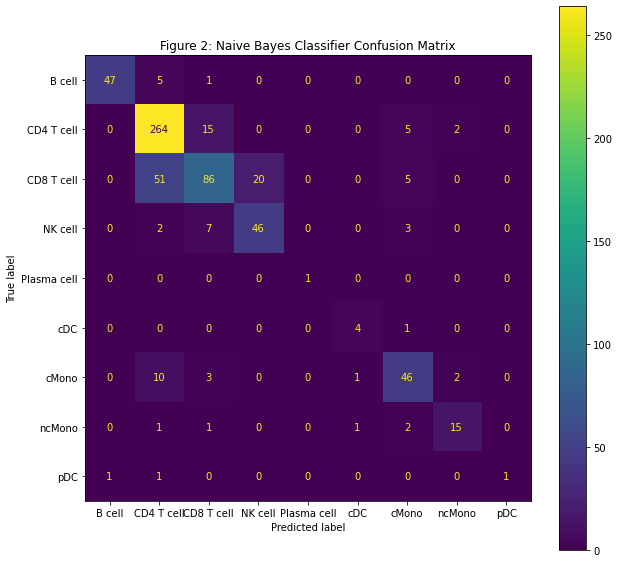

In [11]:
pca = PCA(n_components=15)
gnb = GaussianNB()
gnb.fit(pca.fit_transform(X_train), y_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gnb, pca.transform(X_test), y_test, labels = np.unique(y_test), ax=ax)
ax.set_title("Figure S1: Naive Bayes Classifier Confusion Matrix")
accuracy_score(gnb.predict(pca.transform(X_test)), y_test)

In [55]:
X_tra_train = pca.fit_transform(X_train)

C = 2
kmeans = KMeans(n_clusters=C, random_state=0).fit(X_tra_train)
idx = kmeans.labels_
gNet = GaussianNB().fit(X_tra_train, idx)

Exp = []
for k in range(C):
  Exp.append(SVC(kernel="linear").fit(X_tra_train[idx==k], y_train[idx==k]))

X_tra_test = pca.transform(X_test)
idx_pred = gNet.predict(X_tra_test)
results = np.empty((X_tra_test.shape[0], 1), dtype="<U10")
for k in range(C):
    results[idx_pred==k] = np.reshape(Exp[k].predict(X_tra_test[idx_pred==k]), (-1, 1))
accuracy_score(y_test, results.flatten())

0.9030769230769231

In [63]:
np.unique(y_train[idx==0])

array(['B cell', 'CD4 T cell', 'CD8 T cell', 'NK cell', 'Plasma cell',
       'cDC', 'cMono', 'ncMono', 'pDC'], dtype=object)

In [31]:
(results[idx_pred==2]).shape, (X_tra_test[idx_pred==2]).shape

((369, 1), (369, 15))

0.8784615384615385

In [66]:
knn_dict = {}
for i in np.arange(2, 40, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(pca.fit_transform(X_train), y_train)
    knn_dict[i] = accuracy_score(knn.predict(pca.transform(X_test)), y_test)

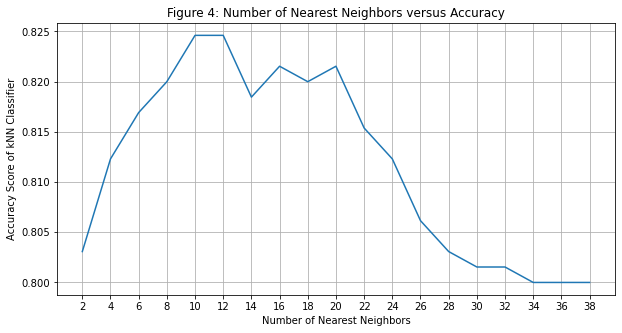

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(knn_dict.keys(), knn_dict.values())
ax.set_xticks(list(knn_dict.keys()))
ax.set_xlabel("Number of Nearest Neighbors")
ax.set_ylabel("Accuracy Score of kNN Classifier")
ax.set_title("Figure 4: Number of Nearest Neighbors versus Accuracy")
ax.grid()

/Users/hongyudemacpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0.8246153846153846

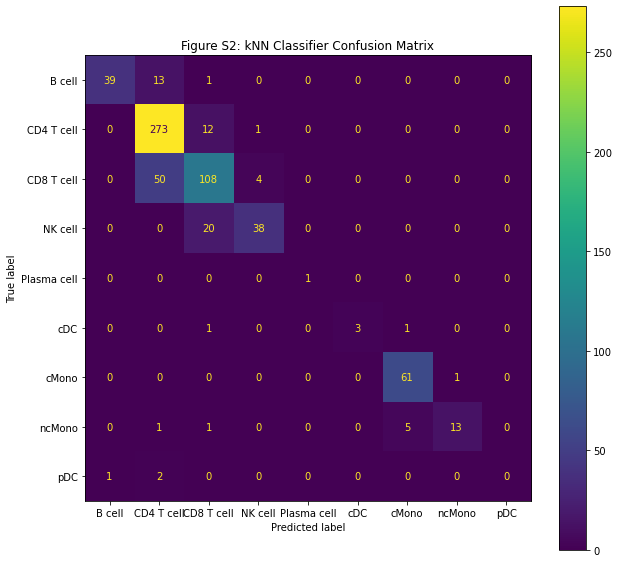

In [86]:
pca = PCA(n_components=15)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(pca.fit_transform(X_train), y_train)
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn, pca.transform(X_test), y_test, labels = np.unique(y_test), ax=ax)
ax.set_title("Figure S2: kNN Classifier Confusion Matrix")
accuracy_score(knn.predict(pca.transform(X_test)), y_test)

In [70]:
np.mean(cross_val_score(knn, pca.transform(X), y))

0.812

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
accuracy_score(y_test, knn.predict(X_test))

0.7871428571428571

In [81]:
pca = PCA(n_components=10)
knn.fit(pca.fit_transform(X_train), y_train)
accuracy_score(y_test, knn.predict(pca.transform(X_test)))

0.7728571428571429

In [61]:
y_pred = np.reshape(gnb.predict(X_test), (1, y_test.shape[0]))

In [64]:
data

,MIR1302-2HG,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP5-857K21.15,RP4-669L17.2,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
CCACGGACATGCTGGC-1,0,0,0,0,0,0,0,0,0,0,...,14,0,8,11,8,1,7,3,0,7
GATTCAGGTCTCCACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,3,0,1,1
TGTATTCTCTATGTGG-1,0,0,0,0,0,0,0,0,0,0,...,48,0,35,34,20,2,28,5,0,18
GTCTCGTGTTCACGGC-1,0,0,0,0,0,0,0,0,0,0,...,24,0,6,5,6,1,6,2,1,5
TATCAGGCACCAACCG-1,0,0,0,0,0,0,0,1,0,0,...,32,0,21,33,20,0,30,7,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTATAGGGC-1,0,0,0,0,0,0,0,0,0,0,...,22,0,7,14,13,2,15,3,0,1
CGATTGACAAGCCATT-1,0,0,0,0,0,0,0,1,0,0,...,15,0,5,15,5,1,10,1,0,5
CTCTGGTCATCGATTG-1,0,0,0,0,0,0,0,0,0,0,...,7,0,0,2,8,0,8,1,0,1
ATTGGTGAGCGTCTAT-1,0,0,0,0,0,0,0,0,0,0,...,3,0,2,2,4,1,2,1,0,0
